## **Imports and Installations:**

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
!pip install pyspark py4j

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=8e235c2322e20150c20f8967020af244da1ec716121490440fe467f4b09f9a6c
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
!ls

sample_data		       spark-3.1.1-bin-hadoop3.2.tgz.1	spark-3.1.1-bin-hadoop3.2.tgz.4
spark-3.1.1-bin-hadoop3.2      spark-3.1.1-bin-hadoop3.2.tgz.2
spark-3.1.1-bin-hadoop3.2.tgz  spark-3.1.1-bin-hadoop3.2.tgz.3


In [ ]:
import os

In [ ]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
import findspark

In [ ]:
  findspark.init()
  from pyspark.sql import SparkSession
  spark = SparkSession.builder.master("local").getOrCreate()
  spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
  spark

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import SparkSession
import  pyspark.sql.functions as fn
import findspark

# Reading Data

In [ ]:
df = spark.read.csv("diabetes.csv", header=True, inferSchema=True)

In [ ]:
df

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0
3,78,50,32,88,31.0,0.248,26,1
10,115,0,0,0,35.3,0.134,29,0
2,197,70,45,543,30.5,0.158,53,1
8,125,96,0,0,0.0,0.232,54,1


In [ ]:
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [ ]:
df.columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

In [ ]:
df.describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|summary|       Pregnancies|          Glucose|     BloodPressure|     SkinThickness|           Insulin|               BMI|DiabetesPedigreeFunction|               Age|           Outcome|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|  count|               768|              768|               768|               768|               768|               768|                     768|               768|               768|
|   mean|3.8450520833333335|     120.89453125|       69.10546875|20.536458333333332| 79.79947916666667|31.992578124999977|      0.4718763020833327|33.240885416666664|0.3489583333333333|
| stddev|  3.36957806269887|31.97261819513622|19.355807170644777|15.95

In [ ]:
df = df.na.drop()

In [ ]:
DiabetesOutcome = df.select("outcome").toPandas()

In [ ]:
DiabetesOutcome

,outcome
0,1
1,0
2,1
3,0
4,1
...,...
763,0
764,0
765,0
766,1


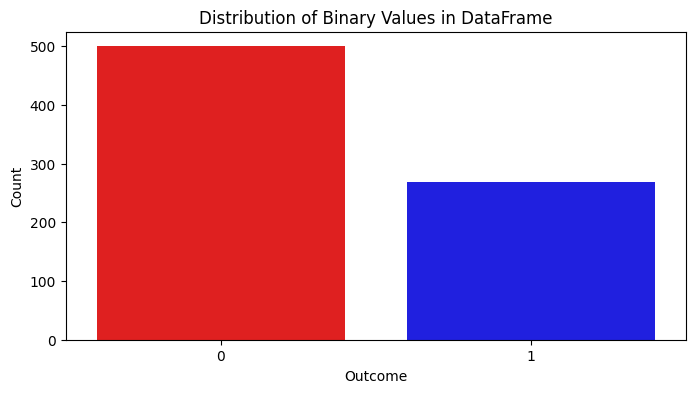

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.countplot(x='outcome', data=DiabetesOutcome, palette=['red', 'blue'])

# Adding labels and title for clarity
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.title('Distribution of Binary Values in DataFrame')
plt.xticks([0, 1], ['0', '1'])

# Display the plot
plt.show()

In [ ]:
selected_features = []
for column in df.columns:
    if column != "Outcome":
        selected_features.append(column)

In [ ]:
assembler = VectorAssembler(inputCols=selected_features, outputCol="assembled_features")

# Setting up StandardScaler
scaler = StandardScaler(inputCol="assembled_features", outputCol="scaled_features")

# Constructing the pipeline with the assembler and scaler
pipeline = Pipeline(stages=[assembler, scaler])

# Applying the pipeline to the dataframe and transforming it
transformed_df = pipeline.fit(df).transform(df)

# Displaying the first three rows of the transformed dataframe
transformed_df.show(n=3)


+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+--------------------+--------------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|  assembled_features|     scaled_features|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+--------------------+--------------------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|[6.0,148.0,72.0,3...|[1.78063837321943...|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|[1.0,85.0,66.0,29...|[0.29677306220323...|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|[8.0,183.0,64.0,0...|[2.37418449762590...|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+--------------------+--------------------+
only s

In [ ]:
# Splitting the dataset into training and testing sets
(train_set, test_set) = transformed_df.randomSplit([0.75, 0.25], seed=123)

# Initializing a Logistic Regression model
log_reg = LogisticRegression(featuresCol="assembled_features", labelCol="Outcome")

# Creating a pipeline with the logistic regression model
log_reg_pipeline = Pipeline(stages=[log_reg])

# Fitting the pipeline model to the training set
trained_model = log_reg_pipeline.fit(train_set)

# Applying the trained model to the test set for predictions
test_predictions = trained_model.transform(test_set)


In [ ]:
# Initializing the binary classification evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Outcome")

In [ ]:
# Computing the AUC score
auc_metric = evaluator.evaluate(test_predictions)

print("AUC (Area Under Curve) Score:", auc_metric)

AUC (Area Under Curve) Score: 0.8268129770992377


In [ ]:
# Calculating precision
correct_predictions = test_predictions.filter(test_predictions["Outcome"] == test_predictions["prediction"]).count()
total_predictions = test_predictions.count()
precision_metric = correct_predictions / total_predictions
print("Precision Metric:", precision_metric)

Precision Metric: 0.8
